# Networks: structure, evolution & processes
**Internet Analytics - Lab 2**

---

**Group:** *D*

**Names:**

* Lejal Glaude Emma
* Bickel Marc
* Cadoux Cyril

---

#### Instructions

*This is a template for part 4 of the lab. Clearly write your answers, comments and interpretations in Markodown cells. Don't forget that you can add $\LaTeX$ equations in these cells. Feel free to add or remove any cell.*

*Please properly comment your code. Code readability will be considered for grading. To avoid long cells of codes in the notebook, you can also embed long python functions and classes in a separate module. Don’t forget to hand in your module if that is the case. In multiple exercises, you are required to come up with your own method to solve various problems. Be creative and clearly motivate and explain your methods. Creativity and clarity will be considered for grading.*

---

## 2.4 PageRank

### 2.4.1 Random Surfer Model

#### Exercise 2.12

In [6]:
# Basic libs
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

##### First we write a function that reads a .graph file and extracts a graph from it :

In [7]:
# Important : Here we parse the nodes from string (file reading) to int  => easier manipulations 

'''This function reads and returns a graph read from a .graph file'''

def read_g (location):
    
    # We use directed graphs here
    G = nx.DiGraph()

    file = open(location, 'r')


    for line in file:

        # Split the file's line into 'words'
        nodes = line.split()

        # The first word is the starting node
        G.add_node(int(nodes[0]))

        # If the starting point has outgoing edges
        if (len(nodes) > 1):
            for i in range (1, len(nodes)):

                # Add those edges
                G.add_edge(int(nodes[0]), int(nodes[i]))  

    file.close()
    
    return G

##### We also define this basic function :

In [8]:
'''The restart function just returns a uniformly chosen node from the graph'''

def restart(G):
    return np.random.choice(G.nodes())

##### We can now define the function that exectutes the random surf on a graph with a certain number of iterations. 

In [12]:
'''Our implementation takes a graph G,
    a number of iterations default=100,
    the version (False(default)/True)
    and a boolean to enable the result printing
    in arguments.
    '''
    

def random_surf(G, iterations=100, enhanced=False):
    
    
    # ======== Init ========
    
    result = np.zeros(G.order())
    damping = 0.15
    
    # The first node chosen at random
    actual_page = restart(G)
    
    # ======== Processing ========
    
    for i in range (iterations):
        
        # Increase the actual_page score by 1
        result[actual_page] += 1
        
        # In enhanced version : apply the random restart with proba 'damping'
        if(enhanced and np.random.uniform() < damping):
            actual_page = restart(G)
        
        else :            
        
            nei = G.neighbors(actual_page)
            dangling = (len(nei) == 0)

            if(dangling and enhanced):            
                actual_page = restart(G)
                
            elif (not(dangling)):
                actual_page = np.random.choice(nei)
            
            # Else we use the naive version and we are on a dangling node => do nothing (see below)
    
    
    # ======== Print ========
    
    for i in range (len(result)):
        print("Node ", i, " has a score of ", result[i])


##### Now we can apply our functions

First We create Ga and Gc from file :

In [13]:
Ga = read_g('../data/absorbing.graph')
Gc = read_g('../data/components.graph')

In [14]:
random_surf(Ga)

Node  0  has a score of  1.0
Node  1  has a score of  94.0
Node  2  has a score of  2.0
Node  3  has a score of  2.0
Node  4  has a score of  1.0


By running the above cell several times, we see that node 1 has in average a very large score. This indicates that this is a dangling node. Indeed, if we ask the length of the neighbors list of node 1, we get : 

In [15]:
print(len(Ga.neighbors(1)))

0


_______

In [16]:
random_surf(Gc)

Node  0  has a score of  27.0
Node  1  has a score of  27.0
Node  2  has a score of  27.0
Node  3  has a score of  19.0
Node  4  has a score of  0.0
Node  5  has a score of  0.0
Node  6  has a score of  0.0
Node  7  has a score of  0.0


By running the above cell several times, we always see that there are only 4 out of 8 nodes that have a non-null score.
This indicated that the graph contains 2 disconnected subgraphs. This is clear if we plot the graph :

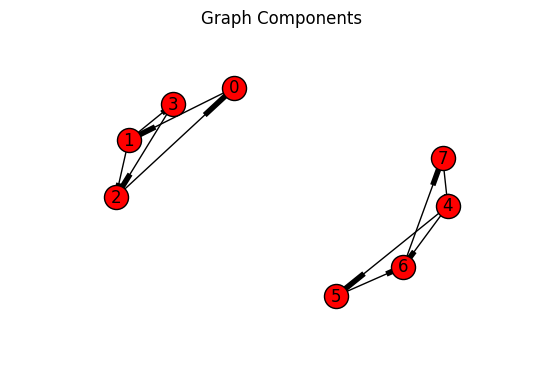

In [26]:
plt.axis('off')
plt.title("Graph Components")
nx.draw_networkx(Gc)

#### Exercise 2.13

##### Now we try the enhanced version of our algorithm

In [33]:
random_surf(Ga,enhanced=True)

Node  0  has a score of  12.0
Node  1  has a score of  35.0
Node  2  has a score of  14.0
Node  3  has a score of  25.0
Node  4  has a score of  14.0


In [37]:
random_surf(Gc, enhanced=True)

Node  0  has a score of  10.0
Node  1  has a score of  10.0
Node  2  has a score of  13.0
Node  3  has a score of  6.0
Node  4  has a score of  17.0
Node  5  has a score of  9.0
Node  6  has a score of  19.0
Node  7  has a score of  16.0


These scores make sense because the random walk is mathematically more likely to reach nodes that have a lot of 'incoming edges'.

In Ga we see that even after the enhancement, node 1 has the best score. This is because 3 other nodes have a hyperlink 'toward' it.

In Gc, we can see that the 2 subgraphs have the same shape : 5<->3, 6<->2, 4<->1 and 7<->0.

And in facts if we run the cell several times, we see that those pairs of nodes have approximately the same PageRank score (eg nodes 5 and 3 often have the lower score).

---

### 2.4.2 Power Iteration Method

#### Exercise 2.14: Power Iteration method

In [38]:
# ======== Initialization cell ========

theta = 0.85

#Our graph
Gw = read_g('../data/wikipedia.graph')

#Our matrices
N = Gw.order()
H = np.zeros((N, N))

In [39]:
# ======== Fill our matrices ========

for node in Gw.nodes() :
    
    neighbors = Gw.neighbors(node)
    odeg = len(neighbors)
    
    #In case of a dangling node
    if odeg == 0:
        for index in range(N):
            H[node][index] = 1.0/N
            
    #In case thera are neighbors
    else :
        for nei in neighbors:
            H[node][nei] = 1.0/odeg
            
G = theta*H + (1-theta)/N

In [40]:
# ====== Computation of the stationnary distribution using the power method ======

# Matrices
pi = np.zeros((N))
newPi = np.zeros((N))
newPi = newPi + 1/N

# Counter
count = 0

# Threshold
espilon = 0.00000000005


# The power method
while( np.linalg.norm(newPi-pi) > espilon):
    
    pi = newPi
    newPi = pi @ G
    
    count += 1
    print("\rNumber of iteration : ", count , end = '')
    
    
print("\n")

Number of iteration :  41



In [45]:
# ====== Extraction of the index of the best referenced nodes ======


#List of tuple that is easy to sort
tuples = list(zip(range(N), newPi))

# Assigning type to tuples
dtype = [('node', int), ('score', float)]

# Assigning this list to nparray with desired dtype
a = np.array(tuples, dtype = dtype)

# Sort in function of the score
tenBest = np.sort(a, order = 'score')[0:10]

# Get the associated id
print("The ten best referenced nodes are :")
for i in range(10):
    print(tenBest[i][0])

The ten best referenced nodes are :
191
244
279
306
315
332
373
378
382
384


---

### 2.4.3 Gaming the system *(Bonus)*

#### Exercise 2.15 *(Bonus)*